In [1]:
import matplotlib
#matplotlib.use('agg')

from ase.io import read,write
import numpy as np

import API_phonopy as api_ph
import API_phonopy_lammps as api_pl
from phonopy import Phonopy
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units

import os
import phonopy.interface.vasp as Intf_vasp 

import AllenFeldman as AF
from phonopy.interface.vasp import read_vasp
from hiphive import ForceConstants

import API_thirdorder as FC3
import thirdorder_core
import thirdorder_common
import matplotlib.pyplot as plt


In [2]:
# Need to activate phono3py environment. 
#Temperatures = [300] multiple temperatures.
load_data = True
T = 300
Qpoints=np.array([[0.0001,0.0001,1.0],[0.5,0.5,1.0],[3./8,3./8,3./4],[0.0,0.0,0.0],[0.5,0.5,0.5]])
band_labels=['$\Gamma$','X','K','$\Gamma$','L']

Nrepeat=[3,3,3]
mesh = [17,17,17]
nneigh = 3

poscar = 'POSCAR'

cmds = ["pair_style eim","pair_coeff * * Na Cl ffield.eim Na Cl"]

Band_points=100
NAC = True
interface_mode = 'vasp'


# compute FC2
prim_cell = Intf_vasp.read_vasp(poscar)
phonon = Phonopy(prim_cell,np.diag(Nrepeat))
phonon.generate_displacements(distance=0.03) # vasp
Scell0 = api_ph.phonopyAtoms_to_aseAtoms(phonon.get_supercell())

Scells_ph = phonon.get_supercells_with_displacements() # This returns a list of Phononpy atoms object

forces = api_pl.calc_lmp_force_sets(cmds,Scells_ph)
phonon.set_forces(forces)
PhonIO.write_FORCE_SETS(phonon.get_displacement_dataset()) # write forces & displacements to FORCE_SET
force_set=PhonIO.parse_FORCE_SETS() # parse force_sets
phonon.set_displacement_dataset(force_set) # force_set is a list of forces and displacements

if NAC == True:
    nac_params = PhonIO.get_born_parameters(
            open("BORN"),
            phonon.get_primitive(),
            phonon.get_primitive_symmetry())
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon._nac_params=nac_params


phonon.produce_force_constants()
phonon.symmetrize_force_constants()
api_ph.write_ShengBTE_FC2(phonon.get_force_constants(), filename='FORCE_CONSTANTS_2ND')
fc2 = phonon.get_force_constants() # get fc2.

# plot dispersion
# bands=api_ph.qpoints_Band_paths(Qpoints,Band_points)
# phonon.set_band_structure(bands,is_eigenvectors=True,labels=band_labels)
# phonon.write_yaml_band_structure()
# bs_plt=phonon.plot_band_structure()
# bs_plt.xlabel("")
# bs_plt.ylabel("Frequency (THz)",fontsize=16)
# bs_plt.xticks(fontsize=16)
# bs_plt.yticks(fontsize=16)
# bs_plt.savefig("Bandstructure.png",dpi=300,bbox_inches='tight')


# compute FC3

poscar = FC3.read_POSCAR(".")
natoms = len(poscar["types"])
symops = thirdorder_core.SymmetryOperations(poscar["lattvec"], poscar["types"], poscar["positions"].T, 1e-5) # symops is an obj.
sposcar = FC3.gen_SPOSCAR(poscar, Nrepeat[0], Nrepeat[1], Nrepeat[2])
FC3.write_POSCAR(sposcar,'SPOSCAR')
ntot = natoms * np.prod(Nrepeat)
dmin, nequi, shifts = FC3.calc_dists(sposcar)
frange = FC3.calc_frange(poscar, sposcar, nneigh, dmin)


wedge = thirdorder_core.Wedge(poscar, sposcar, symops, dmin, nequi, shifts,frange)
list4 = wedge.build_list4()
nirred = len(list4)
nruns = 4 * nirred
width = len(str(4 * (len(list4) + 1)))
namepattern = "3RD.POSCAR.{{0:0{0}d}}".format(width)


Scells = []
phipart = np.zeros((3, nirred, ntot))
p = FC3.build_unpermutation(sposcar)
for i, e in enumerate(list4):
    for n in range(4): 
        isign = (-1)**(n // 2)
        jsign = -(-1)**(n % 2)
        # Start numbering the files at 1 for aesthetic
        # reasons.
        number = nirred * n + i + 1 # the number doesn't follow the order of 1,2,3,... 
        dsposcar = FC3.normalize_SPOSCAR(FC3.move_two_atoms(sposcar, e[1], e[3], isign * thirdorder_common.H, e[0], e[2], jsign * thirdorder_common.H))
        filename = namepattern.format(number)
        FC3.write_POSCAR(dsposcar, filename)
        Scell = read_vasp(filename)
        Scells.append(Scell)
        os.remove(filename)
        #print number
        Scell_ase = api_ph.phonopyAtoms_to_aseAtoms(Scell)
        force = np.array(api_pl.calc_lmp_force(cmds,Scell_ase))
        phipart[:, i, :] -= isign * jsign * force[p, :].T   
     
phipart /= (400. * thirdorder_common.H * thirdorder_common.H)
phifull = thirdorder_core.reconstruct_ifcs(phipart, wedge, list4,poscar, sposcar)
print(phifull.shape)
thirdorder_common.write_ifcs(phifull, poscar, sposcar, dmin, nequi, shifts, frange,"FORCE_CONSTANTS_3RD")

# convert FC3 shengBTE to fc3 for phono3py.
prim = read('POSCAR')
supercell = read('SPOSCAR')
fc3 = ForceConstants.read_shengBTE(supercell, 'FORCE_CONSTANTS_3RD', prim)

api_ph.write_phonopy_fc2_hdf5('fc2.hdf5',fc2)
api_ph.write_phonopy_fc3_hdf5('fc3.hdf5',fc3)

- Storing the coefficients in a dense matrix
(3, 3, 3, 2, 54, 54)


In [3]:
# under construction, compute QHGK thermal conductivity
kappa_sym,kappa_ph_sym,Kxx_mp,Kyy_mp,Kzz_mp,Freqs,weights = AF.calc_QHGK_phono3py(phonon,mesh,T,NAC,load_data)

/home/xinqian/Softwares/API_Phonons/AllenFeldman.py:644: RuntimeWarning: invalid value encountered in true_divide
  Tau_sr = Num/Den # ps


In [4]:
print('QHGK kappa = ')
print(kappa_sym)
print('Phonon RTA kappa = ')
print(kappa_ph_sym)
    

QHGK kappa = 
[[[ 6.19290313e+00  2.94425735e-17  1.35967103e-17]
  [ 2.94425735e-17  6.19290313e+00 -1.71242362e-18]
  [ 1.35967103e-17 -1.71242362e-18  6.19290313e+00]]]
Phonon RTA kappa = 
[[[ 6.07164369e+00  3.02484135e-17  1.47671318e-17]
  [ 3.02484135e-17  6.07164369e+00 -1.95157871e-18]
  [ 1.47671318e-17 -1.95157871e-18  6.07164369e+00]]]


Text(0, 0.5, 'Phonon Frequencies $f_n$ (THz)')

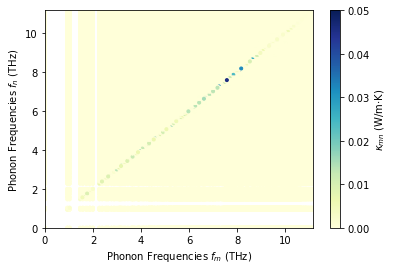

In [5]:
# flatten kxx_mp according to freqeuencies.

Nq,Nbrch = Kxx_mp.shape[:2]

Kxx_mp_flat = np.zeros((Nq*Nbrch,Nq*Nbrch))
Freqs_flat = np.zeros(Nq*Nbrch)

for iq in range(Nq):
    Freqs_flat[iq*Nbrch:(iq+1)*Nbrch] = Freqs[iq]
    Kxx_mp_flat[iq*Nbrch:(iq+1)*Nbrch,iq*Nbrch:(iq+1)*Nbrch] = Kxx_mp[iq]

Wm,Wn = np.meshgrid(Freqs_flat,Freqs_flat)

plt.scatter(Wm,Wn,c=Kxx_mp_flat,marker='.',cmap='YlGnBu')
plt.colorbar(label='$\kappa_{mn}$ (W/m$\cdot$K)')
plt.clim([0,0.05])
plt.xlim([0,np.max(Freqs_flat)])
plt.ylim([0,np.max(Freqs_flat)])
plt.xlabel('Phonon Frequencies $f_m$ (THz)')
plt.ylabel('Phonon Frequencies $f_n$ (THz)')